In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("brazil_data_point_fix.csv")

In [3]:
df.head()

,VECTOR,OCCURRENCE_ID,SOURCE_TYPE,LOCATION_TYPE,POLYGON_ADMIN,Y,X,COUNTRY,COUNTRY_ID,GAUL_AD0,STATUS
0,Aedes aegypti,402,unpublished,polygon,2.0,-32.21,-52.38,Brazil,BRA,37,NaN
1,Aedes aegypti,403,unpublished,polygon,2.0,-31.56,-52.31,Brazil,BRA,37,NaN
2,Aedes aegypti,404,unpublished,polygon,2.0,-30.80,-55.63,Brazil,BRA,37,NaN
3,Aedes aegypti,405,unpublished,polygon,2.0,-30.37,-51.32,Brazil,BRA,37,NaN
4,Aedes aegypti,406,unpublished,polygon,2.0,-30.34,-54.37,Brazil,BRA,37,NaN


In [4]:
existing_points = list(zip(df['X'], df['Y']))

In [5]:
import random
import csv
import json
from typing import List, Tuple, Set, Dict, Any

# Define the boundaries of Brazil 
BRAZIL_BOUNDS = {
    "north": 5.3,
    "south": -33.7,
    "east": -34.8,
    "west": -73.9
}


BRAZIL_POLYGON = [
    [-52.85, 2.08],  # Northern points
    [-51.82, 4.24],
    [-50.42, 1.59],
    [-49.22, 1.84],
    [-47.74, 0.58],
    [-46.91, -0.99],
    [-52.97, -7.93],  # Eastern points
    [-48.45, -10.42],
    [-45.94, -12.26],
    [-44.91, -14.69],
    [-43.68, -16.61],
    [-41.62, -19.61],
    [-40.62, -21.83],
    [-41.17, -22.92],
    [-43.25, -23.00],
    [-45.03, -23.99],
    [-48.02, -25.71],
    [-48.46, -27.37],
    [-50.76, -29.05],
    [-52.96, -30.60],
    [-54.62, -31.49],
    [-55.60, -33.01],  # Southern points
    [-56.97, -30.11],
    [-58.17, -30.10],
    [-57.86, -27.59],
    [-58.14, -25.18],
    [-57.31, -22.34],
    [-58.43, -20.16],
    [-61.74, -15.42],  # Western points
    [-63.58, -10.87],
    [-65.39, -9.76],
    [-66.63, -8.38],
    [-71.41, -10.01],
    [-72.90, -9.43],
    [-73.99, -4.25],
    [-69.43, -0.76],
    [-69.06, 1.09],
    [-61.85, 2.20],
    [-59.99, 1.71],
    [-58.57, 1.56],
    [-56.10, 2.33],
    [-52.85, 2.08]  
]


def is_point_in_polygon(point: Tuple[float, float], polygon: List[List[float]]) -> bool:
    """
    Check if a point is inside a polygon using the ray casting algorithm.
    
    Args:
        point: Tuple of (longitude, latitude)
        polygon: List of [longitude, latitude] points forming a polygon
        
    Returns:
        bool: True if the point is inside the polygon, False otherwise
    """
    x, y = point
    inside = False
    
    for i in range(len(polygon)):
        j = i - 1 if i > 0 else len(polygon) - 1
        
        xi, yi = polygon[i]
        xj, yj = polygon[j]
        
        intersect = ((yi > y) != (yj > y)) and (x < (xj - xi) * (y - yi) / (yj - yi) + xi)
        if intersect:
            inside = not inside
            
    return inside


def generate_random_point() -> Tuple[float, float]:
    """
    Generate a random point within the Brazil bounding box.
    
    Returns:
        Tuple[float, float]: A point as (longitude, latitude)
    """
    lng = random.uniform(BRAZIL_BOUNDS["west"], BRAZIL_BOUNDS["east"])
    lat = random.uniform(BRAZIL_BOUNDS["south"], BRAZIL_BOUNDS["north"])

    return (round(lng, 6), round(lat, 6))


def generate_unique_points_in_brazil(
    count: int, 
    existing_coordinates: List[Tuple[float, float]]
) -> List[Tuple[float, float]]:
    """
    Generate unique points within Brazil that don't exist in the provided set.
    
    Args:
        count: Number of points to generate
        existing_coordinates: List of existing coordinates to avoid
        
    Returns:
        List[Tuple[float, float]]: List of new unique coordinates
    """
    unique_points = []
    existing_set = {(x, y) for x, y in existing_coordinates}
    
    attempts = 0
    max_attempts = count * 10  
    
    print(f"Generating {count} unique points in Brazil...")
    
    while len(unique_points) < count and attempts < max_attempts:
        attempts += 1
        if attempts % 1000 == 0:
            print(f"Made {attempts} attempts, found {len(unique_points)} valid points so far...")
        
        point = generate_random_point()
        
        # Check if the point is in Brazil and not in the existing set
        if is_point_in_polygon(point, BRAZIL_POLYGON) and point not in existing_set:
            unique_points.append(point)
            existing_set.add(point)
    
    if len(unique_points) < count:
        print(f"Warning: Could only generate {len(unique_points)} unique points after {attempts} attempts.")
    else:
        print(f"Successfully generated {count} unique points in {attempts} attempts.")
    
    return unique_points


def save_to_csv(points: List[Tuple[float, float]], filename: str) -> None:
    """
    Save points to a CSV file.
    
    Args:
        points: List of (longitude, latitude) points
        filename: Output filename
    """
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['longitude', 'latitude'])
        writer.writerows(points)
    
    print(f"Saved {len(points)} points to {filename}")


def save_to_geojson(points: List[Tuple[float, float]], filename: str) -> None:
    """
    Save points to a GeoJSON file.
    
    Args:
        points: List of (longitude, latitude) points
        filename: Output filename
    """
    features = []
    
    for point in points:
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": point
            },
            "properties": {}
        }
        features.append(feature)  
    
    geojson = {
        "type": "FeatureCollection",
        "features": features
    }
    
    with open(filename, 'w') as f:
        json.dump(geojson, f, indent=2)
    
    print(f"Saved {len(points)} points to GeoJSON file {filename}")

In [6]:
num_points = 5000
new_points = generate_unique_points_in_brazil(num_points, existing_points)

Generating 5000 unique points in Brazil...
Made 1000 attempts, found 337 valid points so far...
Made 2000 attempts, found 697 valid points so far...
Made 3000 attempts, found 1045 valid points so far...
Made 4000 attempts, found 1414 valid points so far...
Made 5000 attempts, found 1780 valid points so far...
Made 6000 attempts, found 2141 valid points so far...
Made 7000 attempts, found 2483 valid points so far...
Made 8000 attempts, found 2865 valid points so far...
Made 9000 attempts, found 3208 valid points so far...
Made 10000 attempts, found 3562 valid points so far...
Made 11000 attempts, found 3926 valid points so far...
Made 12000 attempts, found 4297 valid points so far...
Made 13000 attempts, found 4667 valid points so far...
Successfully generated 5000 unique points in 13886 attempts.


In [7]:
save_to_csv(new_points, "brazil_coordinates_new.csv")

Saved 5000 points to brazil_coordinates_new.csv


In [8]:
new_data = pd.read_csv("brazil_coordinates_new.csv")

In [9]:
new_data

,longitude,latitude
0,-51.340323,-21.294093
1,-53.815449,-4.460193
2,-53.412585,-21.224285
3,-46.676435,-19.531162
4,-66.217836,-5.086973
...,...,...
4995,-64.510023,-0.473182
4996,-45.037822,-21.059833
4997,-57.901437,-1.709239
4998,-50.088505,-10.347747


In [10]:
df.head()

,VECTOR,OCCURRENCE_ID,SOURCE_TYPE,LOCATION_TYPE,POLYGON_ADMIN,Y,X,COUNTRY,COUNTRY_ID,GAUL_AD0,STATUS
0,Aedes aegypti,402,unpublished,polygon,2.0,-32.21,-52.38,Brazil,BRA,37,NaN
1,Aedes aegypti,403,unpublished,polygon,2.0,-31.56,-52.31,Brazil,BRA,37,NaN
2,Aedes aegypti,404,unpublished,polygon,2.0,-30.80,-55.63,Brazil,BRA,37,NaN
3,Aedes aegypti,405,unpublished,polygon,2.0,-30.37,-51.32,Brazil,BRA,37,NaN
4,Aedes aegypti,406,unpublished,polygon,2.0,-30.34,-54.37,Brazil,BRA,37,NaN


In [11]:
df.shape

(5057, 11)

In [12]:
new_data.rename(columns={'latitude':'Y',
                         'longitude':'X'}, inplace=True)

In [13]:
old_data = df[['X', 'Y', 'LOCATION_TYPE']]

In [14]:
new_data['LOCATION_TYPE'] = 'absense'

In [15]:
output = pd.concat([old_data, new_data])

In [16]:
output.columns

Index(['X', 'Y', 'LOCATION_TYPE'], dtype='object')

In [17]:
output[output['LOCATION_TYPE'] != 'absense']['LOCATION_TYPE'].unique()

array(['polygon', 'point'], dtype=object)

In [18]:
output['LOCATION_TYPE'] = output['LOCATION_TYPE'].str.replace('polygon','presence').str.replace('point', 'presence')

In [19]:
output['LOCATION_TYPE'].value_counts(normalize=True)

LOCATION_TYPE
presence    0.502834
absense     0.497166
Name: proportion, dtype: float64

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import random


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_brazil_coordinates(df, title="Brazil Coordinates by Location Type", figsize=(12, 10)):
    plt.figure(figsize=figsize)
    
    #  Get unique location types
    location_types = df['LOCATION_TYPE'].unique()

    default_colors = plt.cm.tab10(np.linspace(0, 1, len(location_types)))
    
    #  Create a mapping from each LOCATION_TYPE
    color_map = {}
    for i, loc_type in enumerate(location_types):
        if loc_type == 'presence':
            color_map[loc_type] = 'red'
        else:
            color_map[loc_type] = default_colors[i]
    
    
    for loc_type in location_types:
        subset = df[df['LOCATION_TYPE'] == loc_type]
        plt.scatter(
            subset['X'], 
            subset['Y'], 
            c=[color_map[loc_type]], 
            label=loc_type,
            alpha=0.5, 
            s=8, 
            edgecolor='white', 
            linewidth=0.5
        )

    plt.legend(title="Location Types", loc='best')
    plt.title(title, fontsize=14)
    plt.xlabel('Longitude (X)', fontsize=12)
    plt.ylabel('Latitude (Y)', fontsize=12)
    plt.grid(alpha=0.1)
    plt.show()


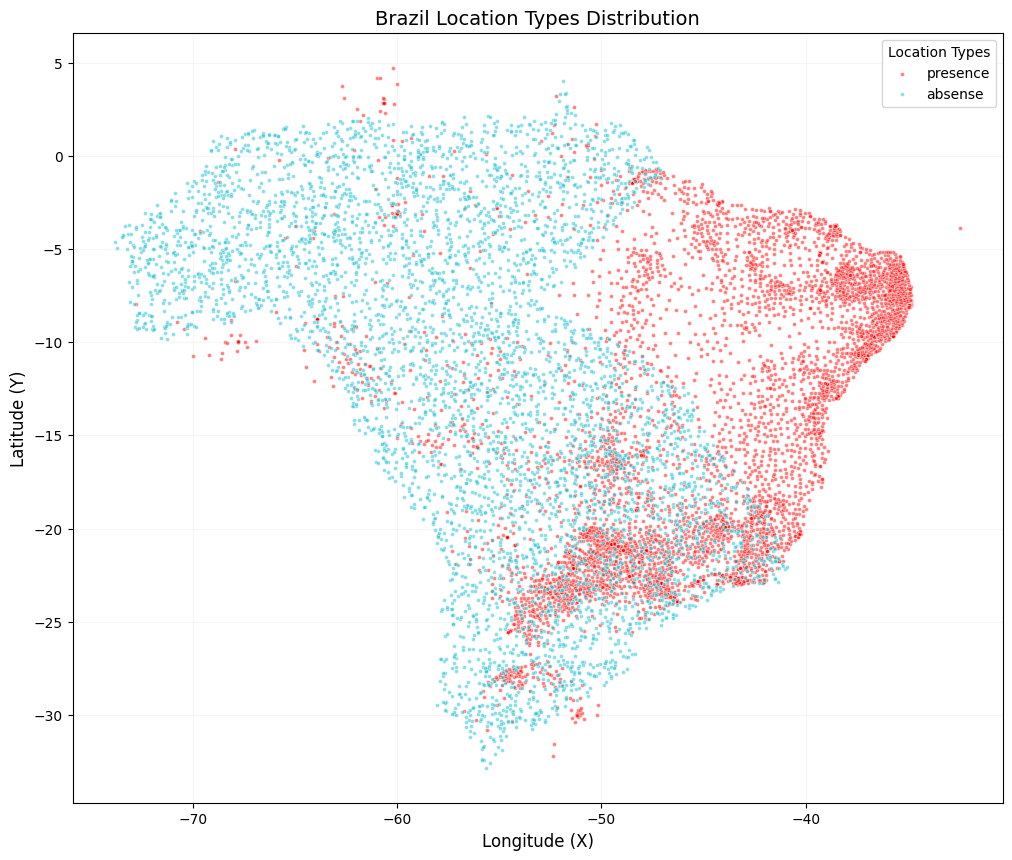

In [22]:
plot_brazil_coordinates(
            output,
            title="Brazil Location Types Distribution",
        )

In [23]:
output.to_csv('pseudo_data.csv', index=False)